In [1]:
!pip install sentence-transformers
!pip install pymorphy2
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=ce5e66367d47a00f67ba13d0fb45f82d207b7864f283262a14cf5904d753ce67
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import json
import pandas as pd
import gensim
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
import sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from google.colab import files

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

import re


def sent_preprocess(text:str):
    preprocessed_text = sent_tokenize(text)
    for i in range(len(preprocessed_text)):
        res = re.sub(r'([^\w\s])|([0-9]+)', '', preprocessed_text[i])
        # res = re.sub(r'', '' ,  res)
        preprocessed_text[i] = (preprocessed_text[i], res)
    
    preprocessed_text = list(filter(lambda sentence: sentence[0] != '', preprocessed_text))
    
    return preprocessed_text



In [4]:
match_df_path = '/content/drive/MyDrive/4th_coursre/Диплом/Colab/match.json'
unmatch_df_path = '/content/drive/MyDrive/4th_coursre/Диплом/Colab/unmatch.json'

In [5]:
match_df = pd.read_json(match_df_path)
unmatch_df = pd.read_json(unmatch_df_path)

# Трансформер: нахождение cos_sim

In [6]:
rubert = SentenceTransformer('DeepPavlov/rubert-base-cased')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# rubert = SentenceTransformer('/content/drive/MyDrive/4th_coursre/Диплом/Colab/rubert-base-cased')

In [7]:
def get_train_test_dfs_for_f1(df_match, df_unmatch): 
    # df_match = shuffle(df_match)
    # df_unmatch = shuffle(df_unmatch)
    
    df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
    df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
    return (df_train_f1, df_test_f1)

In [8]:
def compare_sentences_from_texts(text_1, text_2, top_num=5, count_of_comparings=3):
    sentences_rp = sent_preprocess(text_1)
    sentences_proj = sent_preprocess(text_2)

    def comp(e):
        return e['cos_sim']

    top_number = top_num
    sentences_proj_embeddings = []

    if len(sentences_rp) > count_of_comparings:
        sentences_rp = sentences_rp[:count_of_comparings]

    for sentence_proj in sentences_proj:
        sentences_proj_embeddings += [rubert.encode(sentence_proj[1], convert_to_tensor=True)]

    for sentence_rp in sentences_rp:
        sentence_rp_embedding = rubert.encode(sentence_rp[1], convert_to_tensor=True)
        sim = []
        print(f'RP sentence: {sentence_rp[0]}')
        for i in range(len(sentences_proj_embeddings)):
            sim += [{ 'proj': sentences_proj[i][0], 
                      'cos_sim': float(sentence_transformers.util.cos_sim( sentence_rp_embedding, sentences_proj_embeddings[i]))
                    }]

        sim.sort(key=comp, reverse=True)
        print(f'top {top_number} similarities:')
        count = top_number
        if(len(sim) < top_number):
            count = len(sim)
          
        for i in range(count):
            print('proj: {}\nsim: {}\n'.format(sim[i]['proj'], round(sim[i]['cos_sim'], 3)))
        print('-'*len(sentences_rp[0][0]))

In [9]:
df_train_f1, df_test_f1 = get_train_test_dfs_for_f1(match_df, unmatch_df)

texts_rp = df_train_f1['text_rp'].reset_index().drop(labels='index', axis=1).squeeze()
texts_proj = df_train_f1['text_proj'].reset_index().drop(labels='index', axis=1).squeeze()

In [10]:
df_test_f1

,id_rp,id_proj,name_rp,name_proj,text_rp,text_proj,need_match
12,3490,20,"Спецификация, проектирование и архитектура про...","Построение аналитического решения, включая кор...","Дисциплина «Спецификация, проектирование и арх...","Построение аналитического решения, включая кор...",True
13,4776,34,Web-технологии,Разработка модулей «Кафедра» и «Деканат-2» для...,Курс «Web-технологии» охватывает широкий спект...,Разработка модулей «Кафедра» и «Деканат-2» для...,True
14,4776,8,Web-технологии,"Разработка ИС ""Расписание"" / ""Деканат""",Курс «Web-технологии» охватывает широкий спект...,"Разработка ИС ""Расписание"" / ""Деканат"". Информ...",True
15,4770,48,Машинное обучение,Разработка рекомендательной машины,Дисциплина посвящена знакомству с основными по...,Разработка рекомендательной машины. Рекомендат...,True
16,1447,43,Моделирование нелинейных динамических систем,Нелинейная динамика и приложения теории хаоса,Дисциплина направлена на ознакомление студенто...,Нелинейная динамика и приложения теории хаоса....,True
17,1098,56,Обработка изображений и компьютерное зрение (...,Практика в проектах по автономному транспорту ...,"Рассматриваются основные задачи, модели, метод...",Практика в проектах по автономному транспорту ...,True
18,2195,38,Основы гидроакустики,Разработка системы звукоподводной связи на осн...,2 АННОТАЦИЯ ДИСЦИПЛИНЫ «ОСНОВЫ ГИДРОАКУСТИКИ» ...,Разработка системы звукоподводной связи на осн...,True
19,5089,31,Глубокое обучение,Определение состояния автомобиля используя видео,Глубокое обучение является передовой областью ...,Определение состояния автомобиля используя вид...,True
20,3524,57,Разработка защищенных программных систем,Стажировка в Digital Security по аудиту защищё...,Дисциплина посвящена изучению современных подх...,Стажировка в Digital Security по аудиту защищё...,True
21,3514,26,Технологии автоматизации процесса разработки п...,Программно-аппаратное конфигурирование сети ла...,В курсе рассматриваются вопросы организации пр...,Программно-аппаратное конфигурирование сети ла...,True


In [11]:
compare_sentences_from_texts(texts_rp[0], texts_rp[2], top_num=3, count_of_comparings=2)

RP sentence: Данный курс знакомит слушателей с основами управления беспилотными автомобилями.
top 3 similarities:
proj: Формирование практических навыков разработки распределенных приложений на объектно-ориентированном языке программирования Java.
sim: 0.521

proj: В процессе освоения дисциплины формируются практические навыки разработки распределенных приложений на объектно-ориентированном языке программирования Java с использованием различных моделей взаимодействия процессов.
sim: 0.518

proj: Основные направления дальнейшего развития и практического использования распределенных систем и технологий в искусственном интеллекте.
sim: 0.496

--------------------------------------------------------------------------------
RP sentence: Рассматриваются основные компоненты таких сиcтем: модели и методы восприятия информации при помощи сенсоров или человеко-машинного интерфейса; методы определения собственного положения на известной и неизвестной карте; методы планирования пути (в том числе н

In [12]:
from joblib import Memory

mem = Memory(cachedir='/content/drive/MyDrive/4th_coursre/Диплом/Colab/cache')

<ipython-input-12-c2cffdfde726>:3: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/content/drive/MyDrive/4th_coursre/Диплом/Colab/cache'", use "location='/content/drive/MyDrive/4th_coursre/Диплом/Colab/cache'" instead.
  mem = Memory(cachedir='/content/drive/MyDrive/4th_coursre/Диплом/Colab/cache')


In [13]:
from functools import lru_cache

def compare_sentences_from_texts(text_1, text_2):
    sentences_rp = sent_preprocess(text_1)
    sentences_proj = sent_preprocess(text_2)

    def comp(e):
        return e['cos_sim']

    sentences_proj_embeddings = []

    for sentence_proj in sentences_proj:
        sentences_proj_embeddings += [rubert.encode(sentence_proj[1], convert_to_tensor=True)]
    

    max_sims = []
    for sentence_rp in sentences_rp:
        sentence_rp_embedding = rubert.encode(sentence_rp[1], convert_to_tensor=True)
        sim = []
        # print(f'RP sentence: {sentence_rp[0]}')
        for i in range(len(sentences_proj_embeddings)):
            sim += [{ 'proj': sentences_proj[i][0], 
                      'cos_sim': float(sentence_transformers.util.cos_sim( sentence_rp_embedding, sentences_proj_embeddings[i]))
                    }]

        # sim.sort(key=comp, reverse=True)
        max_sims.append(max(sim, key=comp)['cos_sim'])

    # print(max_sims)
    return np.mean(max_sims)

        

In [14]:
compare_sentences_from_texts(texts_rp[0], texts_proj[2])


0.55134822525939

In [15]:
match_unmatch_df = pd.read_json('/content/drive/MyDrive/4th_coursre/Диплом/Colab/dataset.json')
df_match = match_unmatch_df[ match_unmatch_df['need_match'] == True][:-2]
df_unmatch = match_unmatch_df[match_unmatch_df['need_match'] == False]
df_train_f1, df_test_f1 = get_train_test_dfs_for_f1(df_match, df_unmatch)
texts_rp = df_train_f1['text_rp'].reset_index().drop(labels='index', axis=1).squeeze()
texts_proj = df_train_f1['text_proj'].reset_index().drop(labels='index', axis=1).squeeze()

In [ ]:
# df_train_f1

In [16]:
def maximize_f1_score(texts_rp, texts_proj):
    threshold = 0
    thresholds = []
    max_ = 0
    step_max_ = 0
    step = 0.02
    h = step
    steps = np.linspace(0, 1, num=int(1/h))
    steps = np.round(steps, 2)
    sim = []
    for i in range(len(texts_rp)):
      # print(texts_rp[i])
      # print(texts_proj[i])
      sim += [compare_sentences_from_texts(texts_rp[i], texts_proj[i])]

    for i in steps:
        threshold = calc_f1_score(sim, df_train_f1, h)
        thresholds.append(threshold)
        if threshold > max_:
            max_ = threshold
            step_max_ = h
        h += step
    
    return (steps, thresholds, max_, step_max_)


    


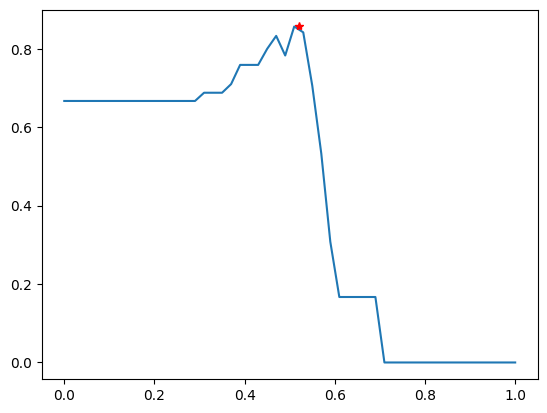

<Figure size 1000x300 with 0 Axes>

Max f1-score is 0.857
Cutoff: 0.5200000000000001


In [17]:
steps, thresholds, max_, step_max_ = maximize_f1_score(texts_rp, texts_proj)
plt.plot(steps, thresholds)
plt.plot(step_max_, max_, 'r*')
plt.figure(figsize=(10,3))
plt.show()

print(f'Max f1-score is {max_}\nCutoff: {step_max_}')

In [18]:
texts_rp_2 = df_test_f1['text_rp'].reset_index().drop(labels='index', axis=1).squeeze()
texts_proj_2 = df_test_f1['text_proj'].reset_index().drop(labels='index', axis=1).squeeze()

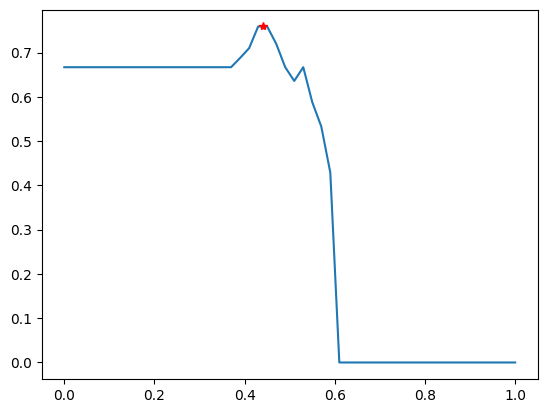

<Figure size 1000x300 with 0 Axes>

Max f1-score is 0.759
Cutoff: 0.4400000000000001


In [19]:
steps_2, thresholds_2, max_2, step_max_2 = maximize_f1_score(texts_rp_2, texts_proj_2)
plt.plot(steps_2, thresholds_2)
plt.plot(step_max_2, max_2, 'r*')
plt.figure(figsize=(10,3))
plt.show()

print(f'Max f1-score is {max_2}\nCutoff: {step_max_2}')

## Leave One Out


In [20]:
def get_train_test_dataframes(df_match, df_unmatch, need_shuffle=True):
  # метод Leave One Out позволяет  
    if need_shuffle:
      df_match = shuffle(df_match)
      df_unmatch = shuffle(df_unmatch)

    df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
    df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
    df_train_f1 = df_train_f1.reset_index().drop(labels='index', axis=1)
    df_test_f1 = df_test_f1.reset_index().drop(labels='index', axis=1)
    return (df_train_f1, df_test_f1)

In [18]:
def get_shuffled_dataframe(df_match, df_unmatch, need_shuffle=True):
    df_match = shuffle(df_match)
    df_unmatch = shuffle(df_unmatch)
    res = pd.concat([pd.DataFrame(df_match), pd.DataFrame(df_unmatch)], axis=0)
    res = res.reset_index().drop(labels='index', axis=1)
    return res

In [22]:
df_train_f1 = get_shuffled_dataframe(df_match, df_unmatch)


In [23]:
df_train_f1

,id_rp,id_proj,name_rp,name_proj,text_rp,text_proj,need_match
0,4770,48,Машинное обучение,Разработка рекомендательной машины,Дисциплина посвящена знакомству с основными по...,Разработка рекомендательной машины. Рекомендат...,True
1,3514,26,Технологии автоматизации процесса разработки п...,Программно-аппаратное конфигурирование сети ла...,В курсе рассматриваются вопросы организации пр...,Программно-аппаратное конфигурирование сети ла...,True
2,998,45,Разработка в ядре Linux,Разработка САПР на основе платформы Beremiz дл...,дисциплина посвящена изучению проектирования к...,Разработка САПР на основе платформы Beremiz дл...,True
3,1040,26,Управление и информатика в технических системах,Программно-аппаратное конфигурирование сети ла...,В рамках данной дисциплины рассматриваются осн...,Программно-аппаратное конфигурирование сети ла...,True
4,1009,4,РАЗРАБОТКА ПРИЛОЖЕНИЙ В РАСПРЕДЕЛЕННОЙ СРЕДЕ,Разработка модулей обработки данных для библио...,Дисциплина посвящена изучению основных принцип...,Разработка модулей обработки данных для библио...,True
5,3524,57,Разработка защищенных программных систем,Стажировка в Digital Security по аудиту защищё...,Дисциплина посвящена изучению современных подх...,Стажировка в Digital Security по аудиту защищё...,True
6,1278,9,Тестирование программного обеспечения,Тестирование конфигураций на платформах: Super...,Дисциплина посвящена изучению теоретических ос...,Тестирование конфигураций на платформах: Super...,True
7,1000,15,АЛГОРИТМЫ БЕСПИЛОТНОГО ТРАНСПОРТА,Разработка системы движения роя дронов в прост...,Данный курс знакомит слушателей с основами упр...,Разработка системы движения роя дронов в прост...,True
8,5089,31,Глубокое обучение,Определение состояния автомобиля используя видео,Глубокое обучение является передовой областью ...,Определение состояния автомобиля используя вид...,True
9,1011,14,Тестирование и сопровождение программного обес...,Тестирование и документирование стенда виртуал...,"Цели дисциплины охватывают ряд направлений, св...",Тестирование и документирование стенда виртуал...,True


In [ ]:
# df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
# df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
# df_train_f1 = df_train_f1.reset_index().drop(labels='index', axis=1)
# df_test_f1 = df_test_f1.reset_index().drop(labels='index', axis=1)

In [ ]:
# df_train_f1

In [33]:
# df_train_f1.drop(2).index.values.tolist() 

In [25]:
N = len(df_train_f1)

sim = []
# считаем 1 раз sim
for i in range(len(df_train_f1)):
  sim += [compare_sentences_from_texts(df_train_f1.loc[i]['text_rp'], df_train_f1.loc[i]['text_proj'])]

In [26]:
def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)
    
def max_f1_score(sim, df):
    threshold = 0
    thresholds = []
    max_ = 0
    step_max_ = 0
    step = 0.02
    h = step
    steps = np.linspace(0, 1, num=int(1/h))
    steps = np.round(steps, 2)

    for i in steps:
        threshold = calc_f1_score(sim, df, h)
        thresholds.append(threshold)
        if threshold > max_:
            max_ = threshold
            step_max_ = h
        h += step
    
    return (steps, thresholds, max_, step_max_)

In [27]:
df_train_f1['need_match'][0]

True

In [28]:
predictions = []
for i in range(N):
    current_df = df_train_f1.drop(i).reset_index().drop(labels='index', axis=1)
    current_sim = sim[:i] + sim[i+1:]
    steps, thresholds, max_, cutoff = max_f1_score(current_sim, current_df)
    print(max_, cutoff)
    if sim[i] >= cutoff:
      predictions.append(True)
    else:
      predictions.append(False)

print(predictions)

0.792 0.48000000000000015
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.792 0.48000000000000015
0.769 0.46000000000000013
0.792 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.792 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.792 0.46000000000000013
0.792 0.46000000000000013
0.778 0.46000000000000013
0.792 0.46000000000000013
0.778 0.46000000000000013
0.792 0.46000000000000013
0.792 0.46000000000000013
0.792 0.46000000000000013
0.792 0.46000000000000013
0.778 0.4600

In [29]:
print(len(predictions))

44


In [30]:

def get_states_leave_one_out(predictions, df):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if predictions[i]: 
                TP += 1
            else:
                FN += 1
        else:
            if predictions[i]: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score_loo(calc_states):
    (TP, FP, FN, TN) = calc_states()
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

In [32]:
calc_f1_score_loo(lambda: get_states_leave_one_out(predictions, df_train_f1))

0.731